In [ ]:
# Challenge 2025-02-27 at 0900
# Four hours to complete the challenge
# Datasets in Google Drive
# Instructions in separate README.txt
# Riku Mäkeläinen

In [ ]:
# Questions & => answers:
# 1) What were the most important technical decisions and on what grounds did you make them?
# => make it as simple, try to finish in given time

# 2) How would you communicate your model's prediction quality to a business stakeholder? Assume limited knowledge of statistics or machine learning on their part.
# => The model is not good as it predicts only 4 out of 6 classes. More work to to build a better model is required. There is a clear list of actions that will surely produce better model.

# 3) If time and/or interest had permitted, how would you have improved on your solution?
# => built better model using biased sampling, variable selection, and other modeling algorithms, for example:

# - check for outliers
# - try variable selection/transformations, principal components
# - transform target to multiple binary variables and model each class separately
# - try logistic regression and neural network, perhaps naive Bayes
# - use under/oversampling to build better model (oversample by randomly or with smote duplicating cases in smaller classes; undersample by randomly removing cases from larger classes)
# - cumulative lift, ROC/AUC-curve to have better evaluation criteria
# - take predicted probability as new target variable and build separate regression or (reg)tree model to explain/visualize the original model
# - introduce MLFlow to control multiple models and to deploy models
# Note: the purpose/application of the model is not known, hence choosing precision/recall/AUC/lift or other criteria as main goal can not be done (cost-profit-matrix could be useful, for sales/marketing purposes going for cumulative lift would make most sense)

In [ ]:
# Structure:
# Import libraries needed
# Import datasets
# Build model
# Explain the model
# Score the x_test.csv (df_x_test) dataset and generate predictions.csv output file
# Explore alternative models
# Model deployment

In [ ]:
pip install seaborn

In [ ]:
pip install kneed

In [ ]:
pip uninstall numpy -y

In [ ]:
pip install numpy==1.24

In [8]:
pip install MiniSom

  Preparing metadata (setup.py) ... done
  Created wheel for MiniSom: filename=MiniSom-2.3.5-py3-none-any.whl size=12032 sha256=d6c4315e8866ff392a138e3376180eb87a35ef8da609676e09098157b78f584c
  Stored in directory: /home/studio-lab-user/.cache/pip/wheels/76/b7/47/eb538cc16f29a1da8734d1548a0c19b642f92e46cd899eac33
Successfully built MiniSom
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Import libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from kneed import KneeLocator
from xgboost import XGBClassifier
import shap
from minisom import MiniSom
import zipfile
import os

In [ ]:
###
# Import datasets
###

In [ ]:
# This part is used if files in GitHub are used, otherwise use the import cells below (those were part of the original challenge where data was delivered via Goodle Drive).
# Unzip the files
with zipfile.ZipFile('x_test_part1.zip', 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile('x_test_part2.zip', 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile('x_train.zip', 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile('y_train.zip', 'r') as zip_ref:
    zip_ref.extractall()
    
# Read the CSV files
df_x_test_part1 = pd.read_csv('x_test_part1.csv')
df_x_test_part2 = pd.read_csv('x_test_part2.csv')
df_x_test = pd.concat([df_x_test_part1, df_x_test_part2], ignore_index=True)

df_x_train = pd.read_csv('x_train.csv')
df_x_test_part2 = pd.read_csv('y_train.csv') 

In [3]:
# Original zip dowloaded to laptop and from there to SageMaker Studiolab

# Import x_test-dataset, rename columns to COL1, COL2, ...
df_x_test = pd.read_csv('x_test.csv', header=None)
df_x_test.columns = [f'COL{i+1}' for i in range(df_x_test.shape[1] - 1)] + ['ID']
print("Rows, columns: ", df_x_test.shape)
print(f"Duplicate row count: {df_x_test[df_x_test.duplicated(subset='ID', keep=False)].shape[0]}")
print('First rows:')
df_x_test.head(5)

Rows, columns:  (4800, 1001)
Duplicate row count: 0
First rows:


COL1      COL2      COL3      COL4      COL5      COL6      COL7  \
0  0.466986  0.940068  0.936647  1.916596  0.566261  0.845571  0.101800   
1  0.728934  0.913009  0.702597  0.885783  0.565379  0.864201  0.336945   
2  0.977341  0.807194  0.598666  0.289551  0.568274  0.847702  1.055096   
3  0.225681  0.900849  0.851252  0.123085  0.561047  0.938914  0.353739   
4  0.411694  0.727791  0.805261  0.292094  0.561952  0.926761  0.556427   

       COL8      COL9     COL10  ...    COL992    COL993    COL994    COL995  \
0  0.327037  0.897099  1.312454  ...  0.996853  1.035089  0.609449  0.058837   
1  0.909036  3.366125  1.167272  ...  1.133631  1.268683  1.007631  0.742551   
2  0.612615  1.259868  0.136373  ...  1.081810  0.280314  1.421475  2.281617   
3  0.441253  0.553648  0.225964  ...  0.879359  1.052568  1.828610  0.746832   
4  0.482158  0.592753  0.523023  ...  1.354237  1.208800  0.356954  0.928384   

     COL996    COL997    COL998    COL999   COL1000  \
0  0.676833  0.482639  0.667861  0.636093  0.763367   
1  0.673346  0.929803  0.802681  0.624777  0.333647   
2  0.413037  0.583962  0.660914  0.619148  0.470799   
3  0.929029  0.888206  0.644901  0.637947  0.461205   
4  3.617595  1.053306  0.663670  0.626969  1.038405   

                                     ID  
0  c25ee611-c243-4808-84fc-c2abc579c0b0  
1  3a5f258c-5a37-4208-9eb6-acdf6942e13f  
2  23c7989a-249b-4498-afa3-dd02c5ea1a15  
3  134866d9-e72e-4b76-abc1-6f6347c4b2af  
4  09bd3970-3745-4074-bc68-2f656e49c6cb  

[5 rows x 1001 columns]

In [4]:
df_x_test.describe()

COL1         COL2         COL3         COL4         COL5  \
count  4800.000000  4800.000000  4800.000000  4800.000000  4800.000000   
mean      0.806161     0.809048     0.830120     0.850906     0.563926   
std       0.665450     0.102139     0.158369     1.148054     0.002702   
min       0.051169     0.443351     0.450620     0.013381     0.553034   
25%       0.386470     0.739085     0.718845     0.236760     0.562123   
50%       0.618466     0.801151     0.815943     0.487263     0.563889   
75%       0.995611     0.872017     0.924712     1.026052     0.565775   
max       8.069469     1.259128     1.651030    16.773999     0.573813   

              COL6         COL7         COL8         COL9        COL10  ...  \
count  4800.000000  4800.000000  4800.000000  4800.000000  4800.000000  ...   
mean      0.850059     0.598210     0.531901     0.882697     0.895546  ...   
std       0.037185     0.377640     0.140671     0.675303     0.944458  ...   
min       0.739927     0.073395     0.216322     0.057276     0.027646  ...   
25%       0.824746     0.339859     0.431424     0.424533     0.338731  ...   
50%       0.848763     0.503739     0.515989     0.690835     0.620395  ...   
75%       0.874780     0.756600     0.614010     1.122445     1.092973  ...   
max       1.007394     3.857415     1.379915     7.308457    14.681137  ...   

            COL991       COL992       COL993       COL994       COL995  \
count  4800.000000  4800.000000  4800.000000  4800.000000  4800.000000   
mean      0.761568     1.166606     0.897611     1.116664     1.434257   
std       0.426032     0.274899     1.717829     0.847523     2.205223   
min       0.122946     0.539350     0.007080     0.081939     0.006800   
25%       0.464183     0.969355     0.220838     0.563784     0.357587   
50%       0.660339     1.132598     0.464988     0.889804     0.752119   
75%       0.948849     1.324141     0.979300     1.421534     1.617667   
max       4.598159     2.628587    56.967025    12.499809    44.948891   

            COL996       COL997       COL998       COL999      COL1000  
count  4800.000000  4800.000000  4800.000000  4800.000000  4800.000000  
mean      0.699825     0.708326     0.667697     0.628532     2.021884  
std       0.318948     0.494810     0.048084     0.014082     3.628765  
min       0.144452     0.053924     0.526344     0.580643     0.013286  
25%       0.473789     0.375040     0.634353     0.619003     0.462038  
50%       0.639152     0.578824     0.665548     0.628271     1.028403  
75%       0.858867     0.895488     0.699524     0.638054     2.227468  
max       3.617595     5.524759     0.854242     0.681310   100.841653  

[8 rows x 1000 columns]

In [5]:
# Check if there are missing values
print("Missing columns: ", df_x_test.columns[df_x_test.isnull().any()])

Missing columns:  Index([], dtype='object')


In [6]:
# Import x_train-dataset, rename columns to COL1, COL2, ...
df_x_train = pd.read_csv('x_train.csv', header=None)
df_x_train.columns = [f'COL{i+1}' for i in range(df_x_train.shape[1] - 1)] + ['ID']
print('Rows, columns: ', df_x_train.shape)
print(f"Duplicate row count: {df_x_train[df_x_train.duplicated(subset='ID', keep=False)].shape[0]}")
print('First rows:')
df_x_train.head(5)

Rows, columns:  (1200, 1001)
Duplicate row count: 0
First rows:


COL1      COL2      COL3      COL4      COL5      COL6      COL7  \
0  0.606214  0.885170  0.827193  0.197169  0.560501  0.890003  1.183692   
1  0.960236  0.761134  0.981690  0.460387  0.556353  0.841962  0.807776   
2  0.666303  0.791899  0.741582  0.203568  0.561863  0.865028  1.127813   
3  0.344948  0.835305  0.874043  0.264302  0.564776  0.876306  0.226912   
4  1.753590  0.895283  0.561427  0.977942  0.564281  0.854353  0.220271   

       COL8      COL9     COL10  ...    COL992    COL993    COL994    COL995  \
0  0.531270  1.010373  1.462041  ...  1.499250  2.113217  1.447677  2.379565   
1  0.408703  0.322817  2.292254  ...  1.155194  0.408494  1.141338  3.194768   
2  0.636855  0.186862  0.688134  ...  0.745066  0.371322  1.549863  2.834910   
3  0.371902  0.408772  0.947090  ...  1.260049  4.605839  0.569633  1.003212   
4  0.724181  1.255830  0.408187  ...  1.019089  2.369277  0.620066  0.431046   

     COL996    COL997    COL998    COL999   COL1000  \
0  1.806187  1.696898  0.662901  0.632434  7.619987   
1  1.964883  0.473063  0.689351  0.618515  0.918748   
2  0.513000  0.691359  0.669160  0.609175  0.900033   
3  0.700921  0.640504  0.719134  0.640261  3.250265   
4  0.381634  1.036588  0.680336  0.609462  0.109194   

                                     ID  
0  1f74519b-b170-4aa2-8976-0ccb30ead4a8  
1  b3864e3b-3fad-41b5-aaa1-bc5866bfc1e5  
2  fcd7a7d6-526f-4395-8906-e8cf9c901b96  
3  4c4b4768-1814-46dc-98a0-1af6aacfa727  
4  4e61ac09-3426-4604-bf0c-4a03b3da43ac  

[5 rows x 1001 columns]

In [7]:
df_x_train.describe()

COL1         COL2         COL3         COL4         COL5  \
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
mean      0.813542     0.809509     0.829943     0.933445     0.563738   
std       0.691136     0.105250     0.157837     1.361166     0.002739   
min       0.072983     0.511986     0.459159     0.010180     0.555443   
25%       0.381158     0.736020     0.718875     0.248755     0.561942   
50%       0.637798     0.799229     0.816829     0.511129     0.563675   
75%       1.014704     0.878127     0.922367     1.122867     0.565630   
max       9.234484     1.203710     1.580278    17.657818     0.572977   

              COL6         COL7         COL8         COL9        COL10  ...  \
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000  ...   
mean      0.850671     0.596394     0.536057     0.901503     0.881957  ...   
std       0.036606     0.403175     0.142018     0.730013     0.893235  ...   
min       0.733294     0.079020     0.248100     0.094475     0.033164  ...   
25%       0.824846     0.324994     0.432985     0.420794     0.337231  ...   
50%       0.849127     0.488955     0.515101     0.675186     0.594763  ...   
75%       0.877075     0.738619     0.619548     1.129682     1.123976  ...   
max       0.961244     4.361652     1.125649     5.236055     9.040820  ...   

            COL991       COL992       COL993       COL994       COL995  \
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
mean      0.739032     1.172289     0.903220     1.116177     1.436584   
std       0.415978     0.268881     1.570613     0.905995     2.426166   
min       0.137429     0.575289     0.014603     0.100278     0.025642   
25%       0.452813     0.983010     0.208284     0.572783     0.346231   
50%       0.645778     1.153089     0.460955     0.897167     0.770677   
75%       0.908917     1.317245     0.925326     1.361668     1.709958   
max       4.776878     2.340347    24.702585    15.032574    44.713134   

            COL996       COL997       COL998       COL999      COL1000  
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000  
mean      0.705550     0.708348     0.664147     0.628223     2.268000  
std       0.320342     0.497100     0.048692     0.013916     3.950166  
min       0.158497     0.087998     0.522749     0.589202     0.015153  
25%       0.483470     0.378213     0.631348     0.618718     0.466308  
50%       0.648706     0.580984     0.660944     0.628530     1.060127  
75%       0.858959     0.889652     0.695181     0.637555     2.498422  
max       2.252384     3.877444     0.851414     0.674695    55.305706  

[8 rows x 1000 columns]

In [8]:
# Check if there are missing values
print("Missing columns: ", df_x_train.columns[df_x_train.isnull().any()])

Missing columns:  Index([], dtype='object')


In [9]:
# Import y_train-dataset, rename columns to ID and TARGET
df_y_train = pd.read_csv('y_train.csv', header=None)
df_y_train.columns = ['ID', 'TARGET']
print('Rows, columns: ', df_y_train.shape)
print(f"Duplicate row count: {df_y_train[df_y_train.duplicated(subset='ID', keep=False)].shape[0]}")
print('First rows:')
df_y_train.head(5)

Rows, columns:  (1200, 2)
Duplicate row count: 0
First rows:


ID  TARGET
0  1f74519b-b170-4aa2-8976-0ccb30ead4a8       3
1  b3864e3b-3fad-41b5-aaa1-bc5866bfc1e5       1
2  fcd7a7d6-526f-4395-8906-e8cf9c901b96       3
3  4c4b4768-1814-46dc-98a0-1af6aacfa727       4
4  4e61ac09-3426-4604-bf0c-4a03b3da43ac       3

In [10]:
# Check target distribution
df_y_counts = df_y_train['TARGET'].value_counts()
df_y_percentages = df_y_train['TARGET'].value_counts(normalize=True) * 100
print(pd.DataFrame({'Count': df_y_counts, 'Percentage': df_y_percentages}).sort_index(ascending=True))

        Count  Percentage
TARGET                   
1          60    5.000000
2         167   13.916667
3         375   31.250000
4         296   24.666667
5          94    7.833333
6         208   17.333333


In [11]:
# Check if there are missing values
df_y_train_missing = df_y_train.columns[df_y_train.isnull().any()]
print(df_y_train_missing)

Index([], dtype='object')


In [12]:
# Create training data by joining x_train to y_train
df_training = pd.merge(df_y_train, df_x_train, on = 'ID')
df_training.head(5)
print('Rows, columns: ', df_training.shape)
print(f"Duplicate row count: {df_training[df_training.duplicated(subset='ID', keep=False)].shape[0]}")
print('First rows:')
df_training.head(5)

Rows, columns:  (1200, 1002)
Duplicate row count: 0
First rows:


ID  TARGET      COL1      COL2      COL3  \
0  1f74519b-b170-4aa2-8976-0ccb30ead4a8       3  0.606214  0.885170  0.827193   
1  b3864e3b-3fad-41b5-aaa1-bc5866bfc1e5       1  0.960236  0.761134  0.981690   
2  fcd7a7d6-526f-4395-8906-e8cf9c901b96       3  0.666303  0.791899  0.741582   
3  4c4b4768-1814-46dc-98a0-1af6aacfa727       4  0.344948  0.835305  0.874043   
4  4e61ac09-3426-4604-bf0c-4a03b3da43ac       3  1.753590  0.895283  0.561427   

       COL4      COL5      COL6      COL7      COL8  ...    COL991    COL992  \
0  0.197169  0.560501  0.890003  1.183692  0.531270  ...  0.939109  1.499250   
1  0.460387  0.556353  0.841962  0.807776  0.408703  ...  0.792574  1.155194   
2  0.203568  0.561863  0.865028  1.127813  0.636855  ...  0.628085  0.745066   
3  0.264302  0.564776  0.876306  0.226912  0.371902  ...  0.996171  1.260049   
4  0.977942  0.564281  0.854353  0.220271  0.724181  ...  0.887662  1.019089   

     COL993    COL994    COL995    COL996    COL997    COL998    COL999  \
0  2.113217  1.447677  2.379565  1.806187  1.696898  0.662901  0.632434   
1  0.408494  1.141338  3.194768  1.964883  0.473063  0.689351  0.618515   
2  0.371322  1.549863  2.834910  0.513000  0.691359  0.669160  0.609175   
3  4.605839  0.569633  1.003212  0.700921  0.640504  0.719134  0.640261   
4  2.369277  0.620066  0.431046  0.381634  1.036588  0.680336  0.609462   

    COL1000  
0  7.619987  
1  0.918748  
2  0.900033  
3  3.250265  
4  0.109194  

[5 rows x 1002 columns]

In [13]:
df_training['TARGET'].value_counts().sort_index(ascending=True)

TARGET
1     60
2    167
3    375
4    296
5     94
6    208
Name: count, dtype: int64

In [ ]:
# Note: number of rows in x_train and y_train match as expected, number of columns is ok, and the target distribution remains same, no missing values.
# Note: target is quite imbalanced, this may cause problems in modeling

In [ ]:
###
# Import datasets ready
###

In [ ]:
###
# Check training data
###

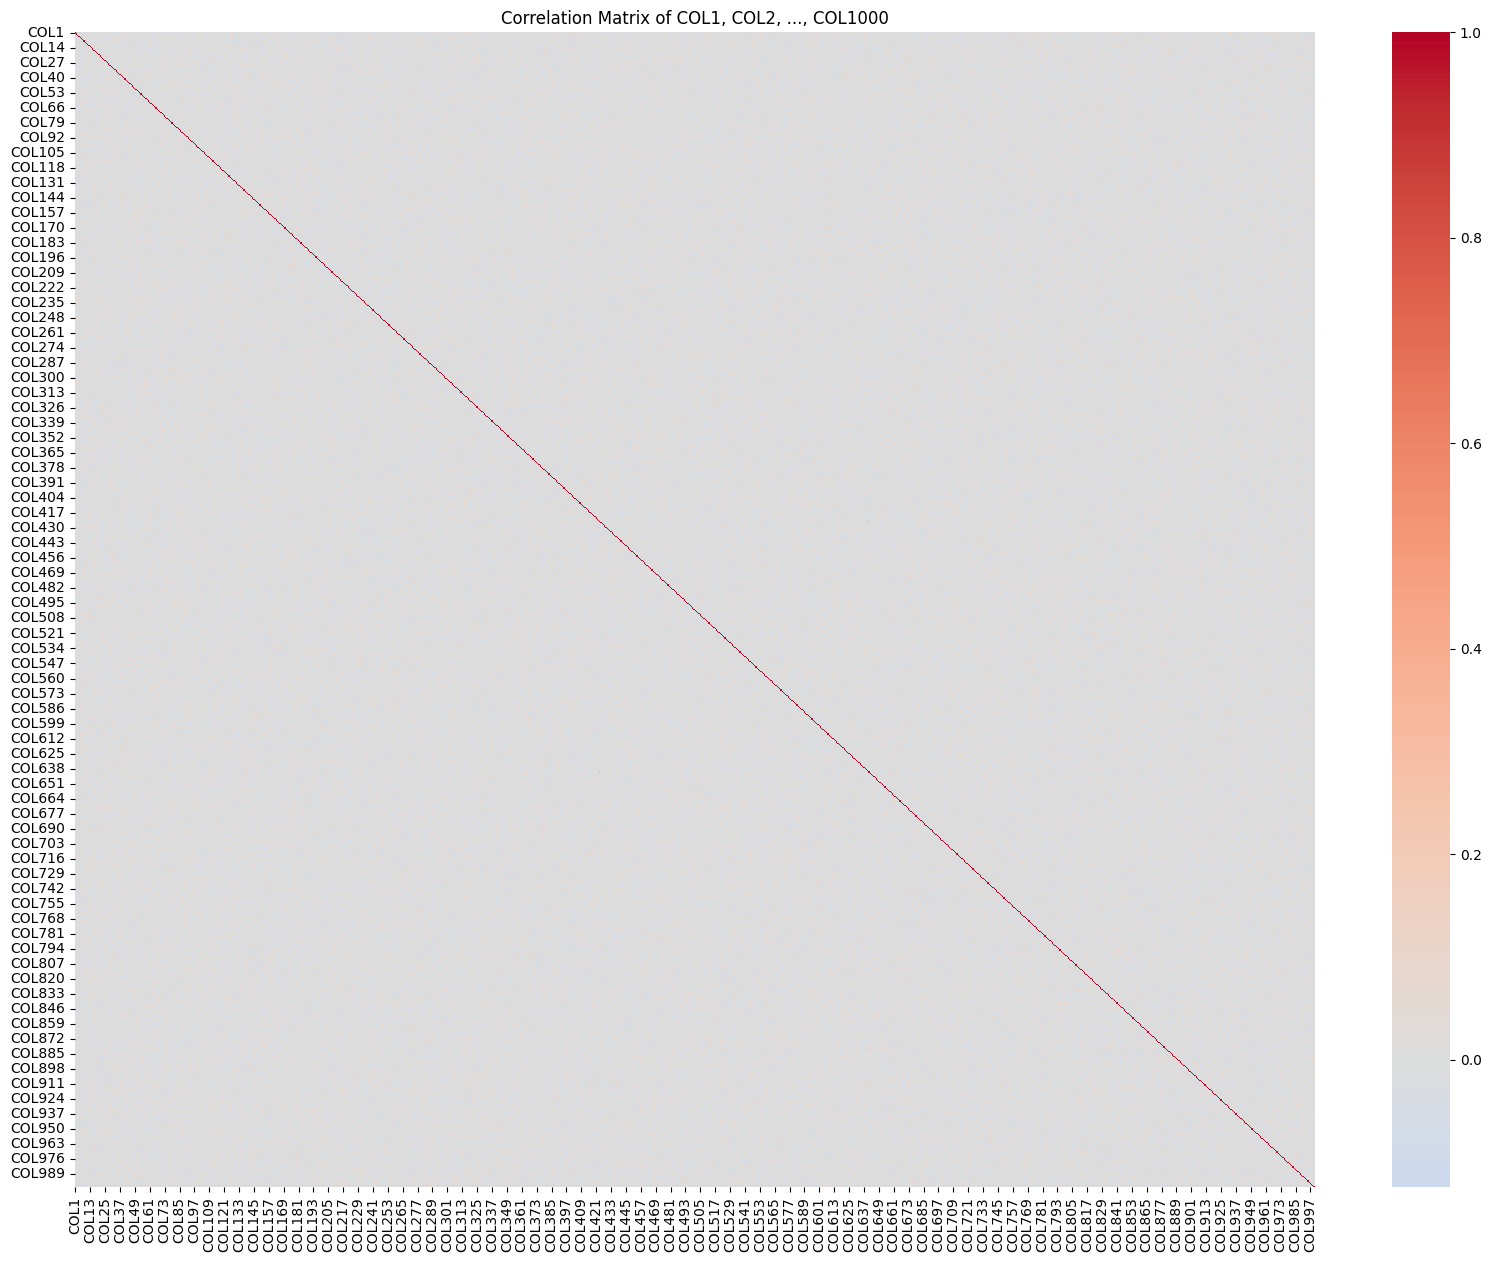

In [14]:
# Check correlations between COL1 to COL1000:
# Assuming df is your DataFrame and it contains columns COL1, COL2, ..., COL1000
# For demonstration, let's create a sample DataFrame with random data
np.random.seed(0)

# Calculate the correlation matrix
df_training_corr_matrix = df_training.iloc[:, 2:].corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(df_training_corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of COL1, COL2, ..., COL1000')
plt.show()

In [ ]:
# Looks not that much correlation

In [15]:
# Build principal components to reduce number of variables
pca = PCA()
pca.fit(df_training.iloc[:, 2:])

PCA()

In [16]:
# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

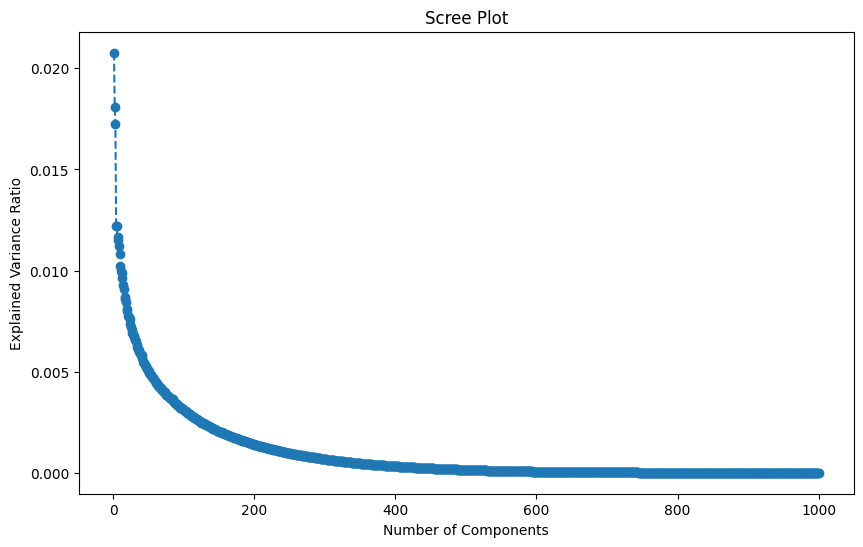

In [17]:
# Plot the explained variance ratio (scree plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

In [ ]:
# Looks principal components probably would not help much

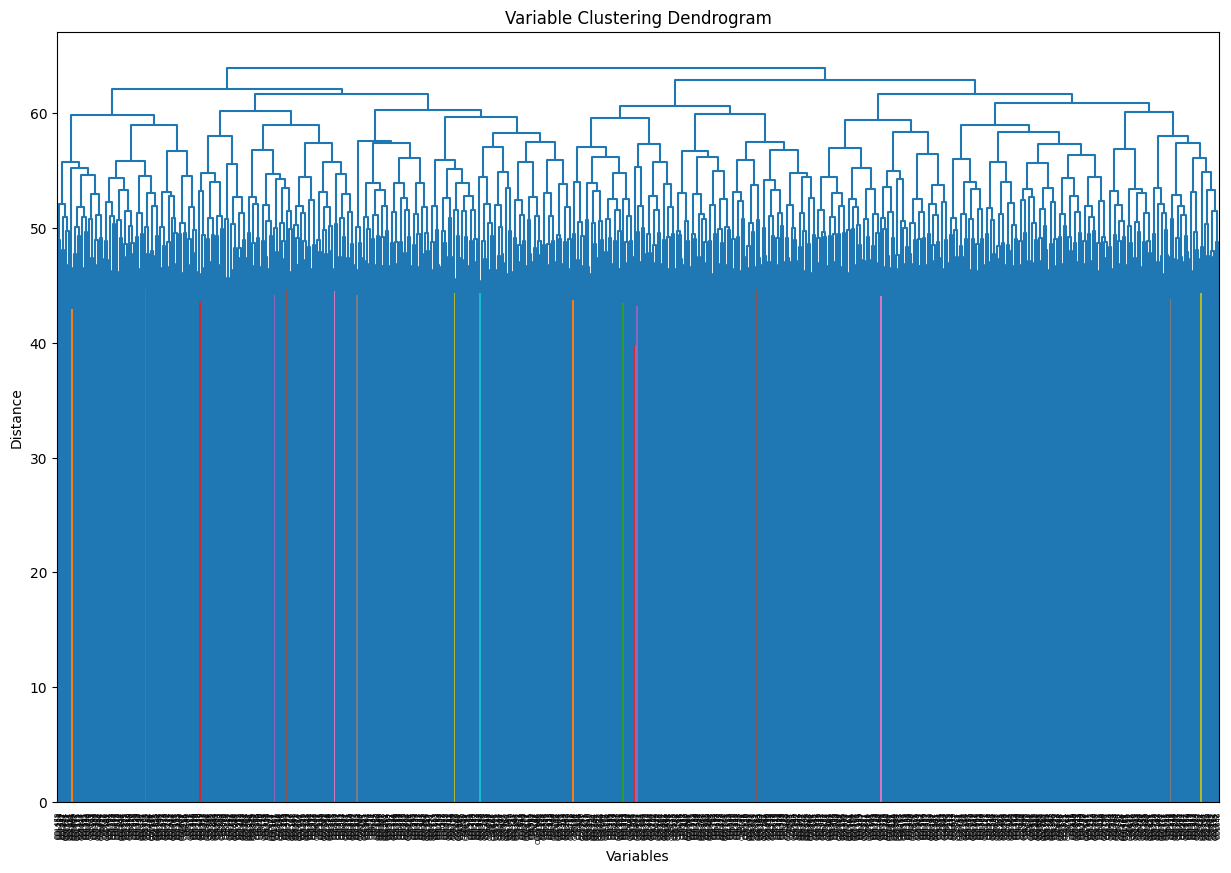

In [18]:
# Do variable clustering to see if number of variables can be reduced
# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_training.drop(['ID','TARGET'], axis=1))

# Perform hierarchical clustering
Z = linkage(df_scaled.T, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(Z, labels=df_training.drop(['ID','TARGET'], axis=1).columns, leaf_rotation=90)
plt.title('Variable Clustering Dendrogram')
plt.xlabel('Variables')
plt.ylabel('Distance')
plt.show()

In [19]:
# Cutpoint 58 seems reasonable, choose that to start with, for the clusters
clusters = fcluster(Z, t=58, criterion='distance')

In [20]:
# Create a DataFrame to see which variables belong to which cluster
clustered_vars = pd.DataFrame({'Variable': df_training.drop(['ID', 'TARGET'], axis=1).columns, 'Cluster': clusters})

In [21]:
clustered_vars

Variable  Cluster
0       COL1       18
1       COL2       21
2       COL3       19
3       COL4       18
4       COL5       11
..       ...      ...
995   COL996        9
996   COL997       21
997   COL998        7
998   COL999        6
999  COL1000       11

[1000 rows x 2 columns]

In [22]:
# Select one variable from each cluster (e.g., the first variable in each cluster)
selected_vars = clustered_vars.groupby('Cluster').first().reset_index()
print(selected_vars)

    Cluster Variable
0         1    COL63
1         2    COL25
2         3    COL48
3         4    COL96
4         5    COL15
5         6    COL14
6         7    COL17
7         8    COL24
8         9     COL7
9        10    COL36
10       11     COL5
11       12     COL9
12       13    COL20
13       14    COL10
14       15     COL6
15       16    COL56
16       17    COL13
17       18     COL1
18       19     COL3
19       20    COL31
20       21     COL2
21       22    COL22
22       23   COL133
23       24    COL32


In [ ]:
# The selection is bit artificial here, more detailed analysis should be done. Side-note: compared to scree plot, 24 variables are not a bad amount

In [ ]:
# Use SOM to have a look at the data

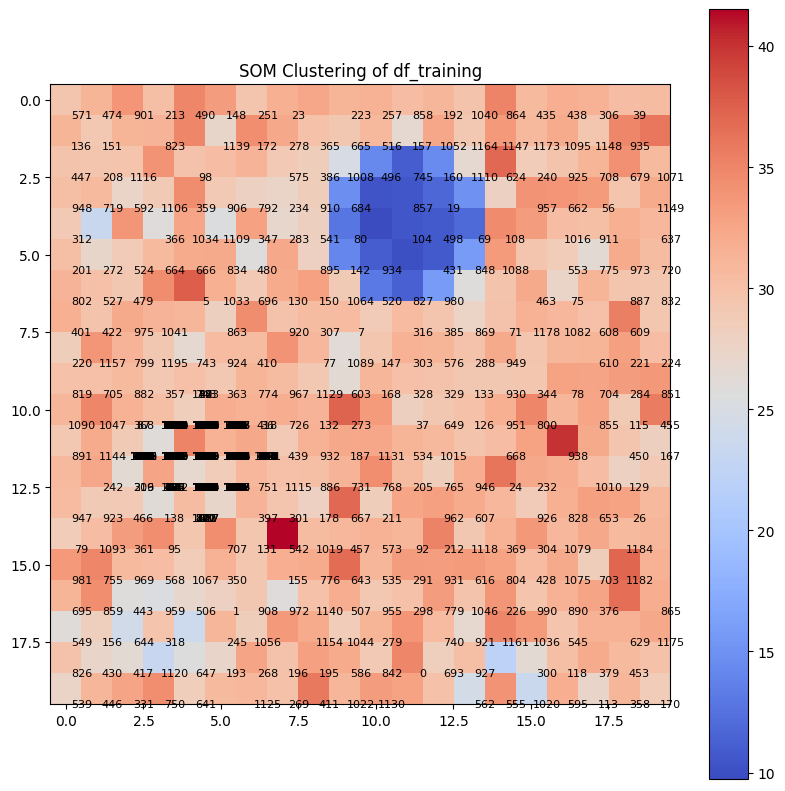

In [24]:
# Standardize the data
scaler2 = StandardScaler()
df_scaled2 = scaler2.fit_transform(df_training.drop(['ID', 'TARGET'], axis=1))

# Initialize and train the SOM
som = MiniSom(x=20, y=20, input_len=df_scaled2.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(df_scaled2)
som.train_random(df_scaled2, 100)

# Plot the resulting SOM
plt.figure(figsize=(10, 10))
heatmap = np.zeros((20, 20))
for i in range(20):
    for j in range(20):
        heatmap[i, j] = np.linalg.norm(som.get_weights()[i, j])

plt.imshow(heatmap, cmap='coolwarm')
plt.colorbar()

for i in range(df_scaled2.shape[0]):
    x, y = som.winner(df_scaled2[i])
    plt.text(x + 0.5, y + 0.5, str(i), fontsize=8, ha='center', va='center', color='black')

plt.title('SOM Clustering of df_training')
plt.show()

In [25]:
cluster_assignments = [som.winner(df_scaled2[i]) for i in range(df_scaled2.shape[0])]

In [26]:
# Create a DataFrame to see which data points belong to which cluster
clustered_data = pd.DataFrame({'Data Point': range(df_scaled2.shape[0]), 'Cluster': cluster_assignments})
# Display the clusters
print(clustered_data)

      Data Point   Cluster
0              0  (11, 18)
1              1   (5, 16)
2              2   (3, 12)
3              3   (5, 11)
4              4   (3, 11)
...          ...       ...
1195        1195    (3, 8)
1196        1196   (2, 11)
1197        1197   (3, 11)
1198        1198   (4, 10)
1199        1199   (4, 12)

[1200 rows x 2 columns]


In [ ]:
# Note: data shows clusters, more analysis is required here...

In [ ]:
###
# Check training data ready
###

In [ ]:
###
# Build model
###

In [ ]:
### Random forest

In [27]:
# Split data to training and testing sets, allocate 20% to test set, use given seed to replace results when needed
# Use the merged dataframe as master
# Separate features and target, exclude ID
x = df_training.drop(['TARGET', 'ID'], axis=1)
y = df_training['TARGET']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [28]:
# Use random forest to model the target
# Note the target is imbalanced so use class_weight to handle this (this gives more weight to the smaller classes, but is this really smart...?)
model1 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight = 'balanced')
model1.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [29]:
# Generate predictions on test-set
y_pred = model1.predict(x_test)

In [30]:
# Evaluate model
# Note the target is imbalanced so use zero_division to handle where there are no predicted samples
accuracy = accuracy_score(y_test, y_pred)
model1_report = classification_report(y_test, y_pred, zero_division=1)

In [31]:
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(model1_report)

Accuracy: 0.31666666666666665
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.00      0.00         9
           2       0.00      0.00      1.00        37
           3       0.33      0.78      0.46        80
           4       0.29      0.23      0.26        60
           5       1.00      0.00      0.00        19
           6       0.00      0.00      1.00        35

    accuracy                           0.32       240
   macro avg       0.44      0.17      0.45       240
weighted avg       0.30      0.32      0.52       240



In [ ]:
# Note: accuracy is not that great, precision and recall leave a lot of room to improve...

In [ ]:
###
# Explain the model
###

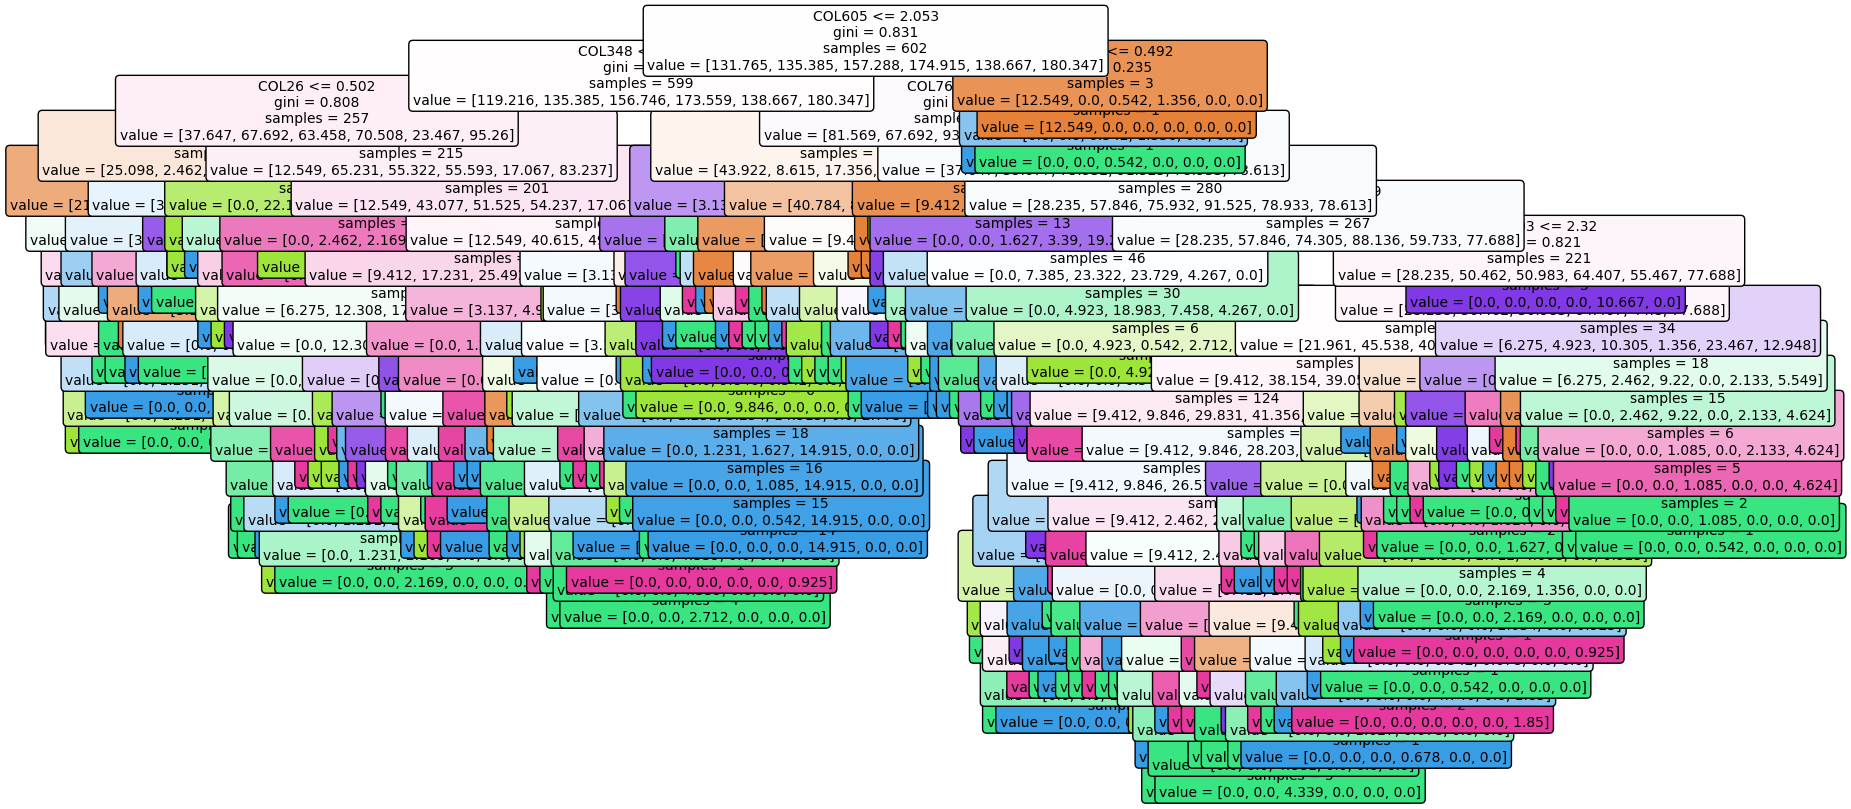

In [32]:
# Explain by visualizing one of the trees
tree = model1.estimators_[0]
# Convers variable names to list for plotting
feature_names = x_train.columns.tolist()
# plot
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=feature_names, filled=True, rounded=True, fontsize=10)
plt.show()

In [33]:
# Check variable importance, take top 10
importances = model1.feature_importances_
feature_importances = pd.DataFrame({'Feature': x_train.columns, 'Importance': importances})
top_10_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)
print(top_10_features)

    Feature  Importance
309  COL310    0.002781
774  COL775    0.002723
411  COL412    0.002709
365  COL366    0.002576
959  COL960    0.002565
153  COL154    0.002324
268  COL269    0.002249
719  COL720    0.002179
701  COL702    0.002130
739  COL740    0.002037


In [ ]:
# Note: explanation could be better, but there is something visual and the most important variables listed...

In [ ]:
###
# Score the x_test.csv (df_x_test) dataset and generate predictions.csv output file
###

In [34]:
# Generate score and export it as csv file predictions.csv.csv, the file should contain only ID and prediction label
df_score = model1.predict(df_x_test.drop(['ID'], axis=1))
df_score_output = pd.DataFrame({
    'ID': df_x_test['ID'],
    'PREDICTION': df_score
})
df_score_output.head()

ID  PREDICTION
0  c25ee611-c243-4808-84fc-c2abc579c0b0           3
1  3a5f258c-5a37-4208-9eb6-acdf6942e13f           3
2  23c7989a-249b-4498-afa3-dd02c5ea1a15           3
3  134866d9-e72e-4b76-abc1-6f6347c4b2af           4
4  09bd3970-3745-4074-bc68-2f656e49c6cb           3

In [35]:
print('Rows, columns: ', df_score_output.shape)

Rows, columns:  (4800, 2)


In [36]:
df_score_output_counts = df_score_output['PREDICTION'].value_counts()
df_score_output_percentages = df_score_output['PREDICTION'].value_counts(normalize=True) * 100
print(pd.DataFrame({'Count': df_score_output_counts, 'Percentage': df_score_output_percentages}).sort_index(ascending=True))

            Count  Percentage
PREDICTION                   
2               7    0.145833
3            3712   77.333333
4             989   20.604167
6              92    1.916667


In [ ]:
# Note: all cases in x_test data got class label prediction value, however only 4 out of 6 target classes are predicted to exist (this is surely wrong, need to build better model and use biased sampling)

In [35]:
# Export as csv
df_score_output.to_csv('predictions.csv', index=False, header=False)

In [ ]:
###
# Explore alternative models
###

In [ ]:
### Explore SVM

In [37]:
# Try Support Vector Machine as an alternative
from sklearn.svm import SVC
# model2 = SVC(decision_function_shape='ovr', random_state=42) # one versus rest
model2 = SVC(decision_function_shape='ovo', random_state=42) # one versus one
model2.fit(x_train, y_train)
accuracy = accuracy_score(y_test, y_pred)
model2_report = classification_report(y_test, y_pred, zero_division=1)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(model2_report)

Accuracy: 0.31666666666666665
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.00      0.00         9
           2       0.00      0.00      1.00        37
           3       0.33      0.78      0.46        80
           4       0.29      0.23      0.26        60
           5       1.00      0.00      0.00        19
           6       0.00      0.00      1.00        35

    accuracy                           0.32       240
   macro avg       0.44      0.17      0.45       240
weighted avg       0.30      0.32      0.52       240



In [ ]:
# Note SVM has equally lousy accuracy and stats

In [38]:
# Generate alternative score using SVM
df_score = model2.predict(df_x_test.drop(['ID'], axis=1))
df_score_output = pd.DataFrame({
    'ID': df_x_test['ID'],
    'PREDICTION': df_score
})
df_score_output.head()

ID  PREDICTION
0  c25ee611-c243-4808-84fc-c2abc579c0b0           3
1  3a5f258c-5a37-4208-9eb6-acdf6942e13f           3
2  23c7989a-249b-4498-afa3-dd02c5ea1a15           4
3  134866d9-e72e-4b76-abc1-6f6347c4b2af           4
4  09bd3970-3745-4074-bc68-2f656e49c6cb           3

In [39]:
print('Rows, columns: ', df_score_output.shape)

Rows, columns:  (4800, 2)


In [40]:
df_score_output_counts = df_score_output['PREDICTION'].value_counts()
df_score_output_percentages = df_score_output['PREDICTION'].value_counts(normalize=True) * 100
print(pd.DataFrame({'Count': df_score_output_counts, 'Percentage': df_score_output_percentages}).sort_index(ascending=True))

            Count  Percentage
PREDICTION                   
2             131    2.729167
3            3032   63.166667
4            1280   26.666667
5               1    0.020833
6             356    7.416667


In [ ]:
# Model predicts 5 classes out of 6, still a lot of room to improve

In [ ]:
### Explore XGBoost

In [41]:
# Extract features and target
# Note: XGBoost expects target to begin from 0 rather than 1 so adjust y
x = df_training.drop(['TARGET', 'ID'], axis=1)
y = df_training['TARGET'] -1
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [42]:
# Train XGBoost classifier
model3 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model3.fit(x_train, y_train)

`use_label_encoder` is deprecated in 1.7.0.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [43]:
# Make prediction on the test set to evaluate model
y_pred = model3.predict(x_test)

In [44]:
# Produce classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.33      0.08      0.13        37
           2       0.47      0.70      0.56        80
           3       0.34      0.45      0.39        60
           4       0.00      0.00      0.00        19
           5       0.30      0.26      0.28        35

    accuracy                           0.40       240
   macro avg       0.24      0.25      0.23       240
weighted avg       0.34      0.40      0.34       240



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [45]:
# Score the x_test.csv (df_x_test) dataset using model3
df_score = model3.predict(df_x_test.drop(['ID'], axis=1))
df_score_output = pd.DataFrame({
    'ID': df_x_test['ID'],
    'PREDICTION': df_score
})
df_score_output.head()

ID  PREDICTION
0  c25ee611-c243-4808-84fc-c2abc579c0b0           3
1  3a5f258c-5a37-4208-9eb6-acdf6942e13f           5
2  23c7989a-249b-4498-afa3-dd02c5ea1a15           2
3  134866d9-e72e-4b76-abc1-6f6347c4b2af           3
4  09bd3970-3745-4074-bc68-2f656e49c6cb           2

In [46]:
df_score_output_counts = df_score_output['PREDICTION'].value_counts()
df_score_output_percentages = df_score_output['PREDICTION'].value_counts(normalize=True) * 100
print(pd.DataFrame({'Count': df_score_output_counts, 'Percentage': df_score_output_percentages}).sort_index(ascending=True))

            Count  Percentage
PREDICTION                   
0              16    0.333333
1             232    4.833333
2            2531   52.729167
3            1477   30.770833
4              22    0.458333
5             522   10.875000


In [ ]:
# XGBoost seems to produce predictions that contain all six classes

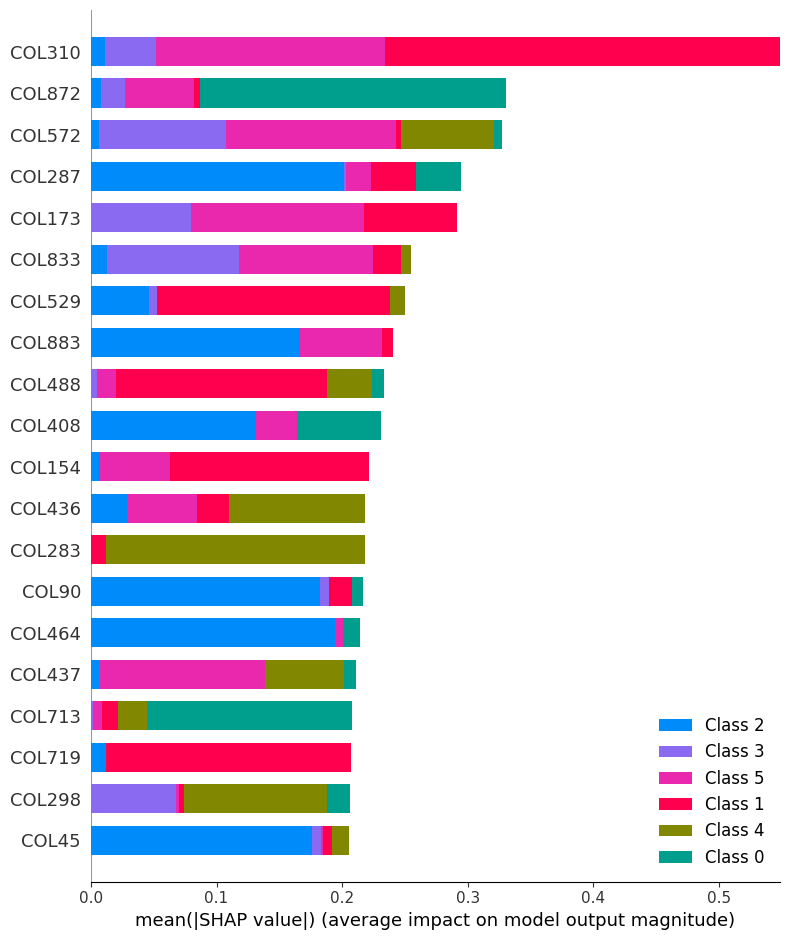

In [47]:
# Use SHAP values to explain model
explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)

In [ ]:
# COL310 seems to be the most important variable. All the variables seem to have positive contribution to prediction. Target class 1 seems to be dominant on COL310.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


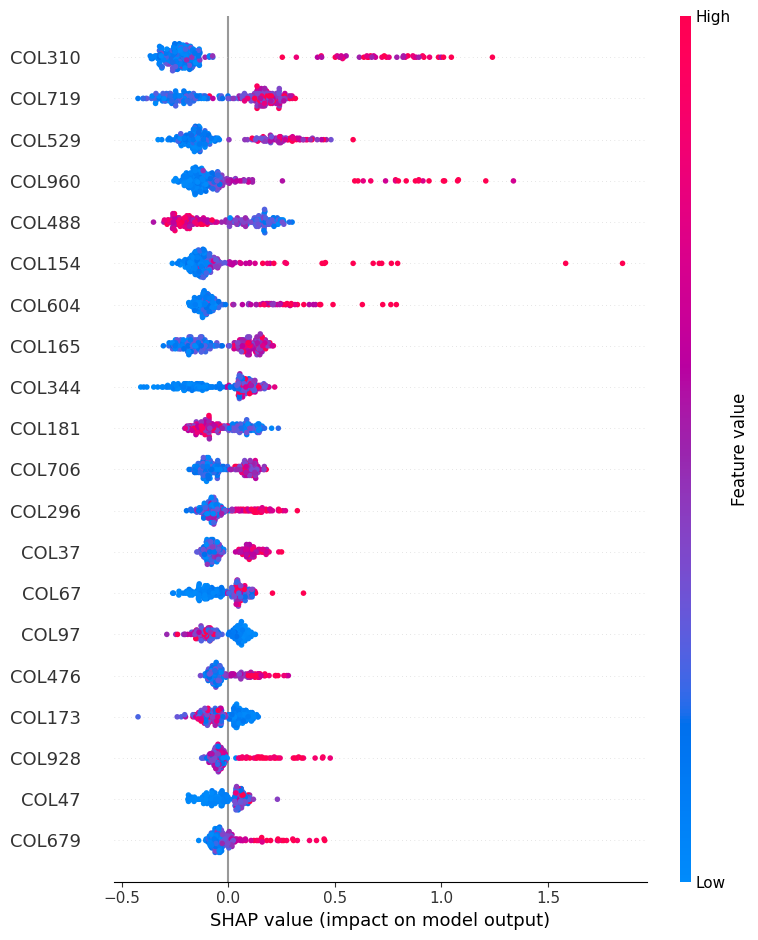

In [65]:
# Check summary plots for each label (only 1 below to save space...)
shap.summary_plot(shap_values[1], x_test)

In [ ]:
### Explore random forest with grid search

In [ ]:
# Try random forest with different parameters, run a grid search to find best parameters

In [117]:
# Note this will take time...
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Run the models in grid search
model3 = RandomForestClassifier(random_state = 42, class_weight = 'balanced')
grid_search = GridSearchCV(estimator = model3, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(x_train, y_train)

# Print best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estim


1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
504 fits failed with the following error:
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-p

Best parameters found:  {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [119]:
model3b = RandomForestClassifier(bootstrap = False, max_depth = None, max_features = 'log2', min_samples_leaf = 2, min_samples_split = 5, n_estimators = 200, random_state=42, class_weight = 'balanced')
model3b.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [120]:
# Make prediction on the test set to evaluate model
y_pred = model3b.predict(x_test)

# Produce classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        37
           2       0.34      0.79      0.47        80
           3       0.37      0.30      0.33        60
           4       0.00      0.00      0.00        19
           5       0.25      0.03      0.05        35

    accuracy                           0.34       240
   macro avg       0.16      0.19      0.14       240
weighted avg       0.24      0.34      0.25       240



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [121]:
# Score the x_test.csv (df_x_test) dataset using model3
df_score = model3b.predict(df_x_test.drop(['ID'], axis=1))
df_score_output = pd.DataFrame({
    'ID': df_x_test['ID'],
    'PREDICTION': df_score
})
df_score_output.head()

ID  PREDICTION
0  c25ee611-c243-4808-84fc-c2abc579c0b0           2
1  3a5f258c-5a37-4208-9eb6-acdf6942e13f           3
2  23c7989a-249b-4498-afa3-dd02c5ea1a15           3
3  134866d9-e72e-4b76-abc1-6f6347c4b2af           2
4  09bd3970-3745-4074-bc68-2f656e49c6cb           3

In [122]:
df_score_output_counts = df_score_output['PREDICTION'].value_counts()
df_score_output_percentages = df_score_output['PREDICTION'].value_counts(normalize=True) * 100
print(pd.DataFrame({'Count': df_score_output_counts, 'Percentage': df_score_output_percentages}).sort_index(ascending=True))

            Count  Percentage
PREDICTION                   
1               3    0.062500
2            3664   76.333333
3            1065   22.187500
5              68    1.416667


In [ ]:
# Note not much improvement

In [ ]:
###
# Explore alternative models ends
###

In [ ]:
###
# Model deployment
###

In [47]:
# Save the random forest model model1 to a pickle file for using in API
import pickle
with open('model1.pkl', 'wb') as file:
    pickle.dump(model1, file)

In [66]:
# Create REST API
from flask import Flask, request, jsonify
import pandas as pd
import pickle
import threading

app = Flask(__name__)

# Load the model
with open('model1.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# Load the dataset
data = pd.read_csv('x_test.csv', header=None)

# Manually assign column names
column_names = [f'COL{i}' for i in range(1, 1001)] + ['ID']
data.columns = column_names

@app.route('/predictions/<user_id>', methods=['GET'])
def get_prediction(user_id):
    # Find the user data by ID
    user_data = data[data['ID'] == user_id]
    
    if user_data.empty:
        return jsonify({"error": "User ID not found"}), 404
    
    # Drop the ID column and get the features
    features = user_data.drop(columns=['ID'])
    
    # Make a prediction
    prediction = model.predict(features)
    
    # Return the prediction as JSON
    return jsonify({"class": int(prediction[0])})

def run_app():
    app.run(debug=True, port=5005, use_reloader=False)

if __name__ == '__main__':
    threading.Thread(target=run_app).start()

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5005
Press CTRL+C to quit
127.0.0.1 - - [06/Mar/2025 07:21:56] "GET /predictions/e554b320-0ab6-489e-bc40-eb132946b85a HTTP/1.1" 200 -
127.0.0.1 - - [06/Mar/2025 07:23:10] "GET /predictions/c25ee611-c243-4808-84fc-c2abc579c0b0 HTTP/1.1" 200 -
127.0.0.1 - - [06/Mar/2025 07:23:41] "GET /predictions/cab HTTP/1.1" 404 -


In [114]:
# Test responses
import requests

# Case 1, from readme.txt
response = requests.get('http://127.0.0.1:5005/predictions/e554b320-0ab6-489e-bc40-eb132946b85a')
print(response.json())

127.0.0.1 - - [04/Mar/2025 09:25:14] "GET /predictions/e554b320-0ab6-489e-bc40-eb132946b85a HTTP/1.1" 200 -


{'class': 3}


In [115]:
# Case 2, user that should not be there
response = requests.get('http://127.0.0.1:5005/predictions/abc123')
print(response.json())

127.0.0.1 - - [04/Mar/2025 09:25:16] "GET /predictions/abc123 HTTP/1.1" 404 -


{'error': 'User ID not found'}


In [116]:
# Case 3 , user that is on the first row of x_test.csv-file
response = requests.get('http://127.0.0.1:5005/predictions/c25ee611-c243-4808-84fc-c2abc579c0b0')
print(response.json())

127.0.0.1 - - [04/Mar/2025 09:25:18] "GET /predictions/c25ee611-c243-4808-84fc-c2abc579c0b0 HTTP/1.1" 200 -


{'class': 3}


In [ ]:
###
# Test deploying the XGBoost-model
###

In [48]:
# Save the random forest model model1 to a pickle file for using in API
import pickle
with open('model3.pkl', 'wb') as file:
    pickle.dump(model3, file)

In [63]:
# Create REST API
from flask import Flask, request, jsonify
import pandas as pd
import pickle
import threading

app = Flask(__name__)

# Load the model
with open('model3.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# Load the dataset
data = pd.read_csv('x_test.csv', header=None)

# Manually assign column names
column_names = [f'COL{i}' for i in range(1, 1001)] + ['ID']
data.columns = column_names

@app.route('/predictions/<user_id>', methods=['GET'])
def get_prediction(user_id):
    # Find the user data by ID
    user_data = data[data['ID'] == user_id]
    
    if user_data.empty:
        return jsonify({"error": "User ID not found"}), 404
    
    # Drop the ID column and get the features
    features = user_data.drop(columns=['ID'])
    
    # Make a prediction
    prediction = model.predict(features)
    
    # Return the prediction as JSON
    return jsonify({"class": int(prediction[0])})

def run_app():
    app.run(debug=True, port=5001, use_reloader=False)

if __name__ == '__main__':
    threading.Thread(target=run_app).start()

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit


In [67]:
# Test responses
import requests

# Case 1, from readme.txt
response = requests.get('http://127.0.0.1:5001/predictions/e554b320-0ab6-489e-bc40-eb132946b85a')
print(response.json())

127.0.0.1 - - [06/Mar/2025 07:24:12] "GET /predictions/e554b320-0ab6-489e-bc40-eb132946b85a HTTP/1.1" 200 -


{'class': 3}


In [69]:
# Case 2, user that should not be there
response = requests.get('http://127.0.0.1:5001/predictions/abc123')
print(response.json())

127.0.0.1 - - [06/Mar/2025 07:30:00] "GET /predictions/abc123 HTTP/1.1" 404 -


{'error': 'User ID not found'}


In [ ]:
# For testing in terminal
python model3_app.py
curl -X GET http://127.0.0.1:5001/predictions/e554b320-0ab6-489e-bc40-eb132946b85a

In [ ]:
# Using Docker in SageMaker Studio Lab is not possible